# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init, doubleJetCase_meargs = doubleJetCase.getInitConditions()

In [7]:
coarse_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
coarse_doubleJetCase_args, coarse_doubleJetCase_init, _ = coarse_doubleJetCase.getInitConditions()

In [8]:
doubleJetCase_meargs = {
                            "basis_x_start": 2, 
                            "basis_x_end": 8,
                            "basis_y_start": 1,
                            "basis_y_end": 7,

                            "kl_decay": 1.25,
                            "kl_scaling": 0.025,
                            }

sim_model_error_time_step = 60.0                       

In [18]:
ML_Nes = [100, 50]
doubleJetCase_args_list = [coarse_doubleJetCase_args, doubleJetCase_args]
doubleJetCase_init_list = [coarse_doubleJetCase_init, doubleJetCase_init]

In [19]:
mekls = []
for l_idx in range(len(doubleJetCase_args_list)): 
    grid_args = {key: doubleJetCase_args_list[l_idx][key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
    mekls.append( ModelErrorKL.ModelErrorKL(gpu_stream=gpu_stream, **grid_args, **doubleJetCase_meargs) )

In [20]:
## MultiLevel ensemble
ML_ensemble = []

# 0-level
lvl_ensemble = []
for i in range(ML_Nes[0]):
    if i % 100 == 0: print(i)
    sim = CDKLM16.CDKLM16(**doubleJetCase_args_list[0], **doubleJetCase_init_list[0]) 

    sim.model_error = mekls[0]
    sim.model_time_step = sim_model_error_time_step
    lvl_ensemble.append( sim )

ML_ensemble.append(lvl_ensemble)

# diff-levels
for l_idx in range(1,len(ML_Nes)):
    print(l_idx)
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    for e in range(ML_Nes[l_idx]):
        sim0 = CDKLM16.CDKLM16(**doubleJetCase_args_list[l_idx], **doubleJetCase_init_list[l_idx]) 
        sim1 = CDKLM16.CDKLM16(**doubleJetCase_args_list[l_idx-1], **doubleJetCase_init_list[l_idx-1])

        sim0.model_error = mekls[l_idx]
        sim1.model_error = mekls[l_idx-1]

        sim0.model_time_step = sim_model_error_time_step
        sim1.model_time_step = sim_model_error_time_step

        lvl_ensemble0.append(sim0)
        lvl_ensemble1.append(sim1)
    
    ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])

0
1


In [21]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [29]:
MLOceanEnsemble.stepToObservation(300)

In [22]:
from utils.DoubleJetPlot import *

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

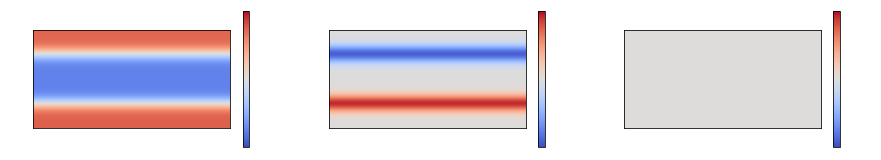

In [25]:
imshow3(MLOceanEnsemble.estimate(np.mean))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

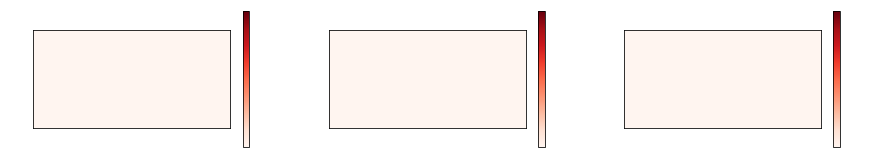

In [26]:
imshow3var(MLOceanEnsemble.estimate(np.std), eta_vlim=0.5, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

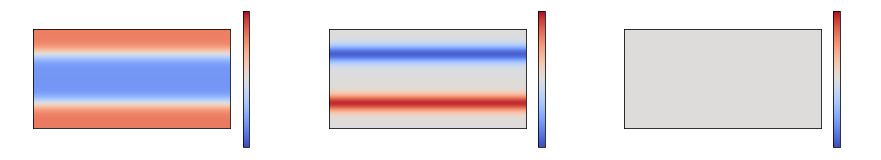

In [27]:
imshowSim(MLOceanEnsemble.ML_ensemble[1][0][1], eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

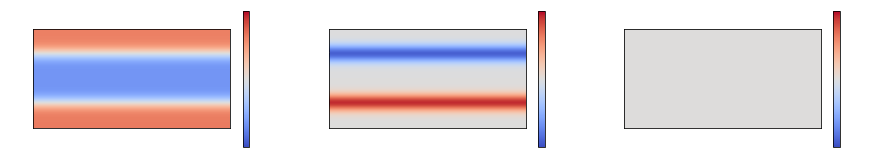

In [28]:
imshowSim(MLOceanEnsemble.ML_ensemble[1][1][1], eta_vlim=3.5, huv_vlim=750)